In [1]:
import pandas as pd
import pandas_ta as pdt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import evds as ev
import requests
import json
from urllib.parse import urlencode
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [43]:
with open("C:/Users/okand/OneDrive/Desktop/Works/evds_api.txt") as file:
    api_key = file.read()

data_columns={"bist100":"TP.MK.F.BILESIK",
              "bist_islem_hacmi":"TP.MK.ISL.HC",
             "tufe":"TP.FG.J0",
             "ufe":"TP.TUFE1YI.T1",
             "bendeks":"TP.FE.OKTG03",
             "cendeks":"TP.FE.OKTG04",
             "usdtl":"TP.DK.USD.A.YTL",
             "eurtl":"TP.DK.EUR.A.YTL",
             "brentpetrol":"TP.BRENTPETROL.EUBP",
             "tuketici_kredi_faizi":"TP.KTFTUK",
              "1_aya_kad_mev_faizi":"TP.TRY.MT01",
              "3_aya_kad_mev_faizi":"TP.TRY.MT02",
              "6_aya_kad_mev_faizi":"TP.TRY.MT04",
              "1_yıla_kad_mev_faizi":"TP.TRY.MT05",
             "altın":"TP.MK.KUL.YTL",
             "paraarzı_M1":"TP.PR.ARZ01",
             "paraarzı_M2":"TP.PR.ARZ13",
             "paraarzı_M3":"TP.PR.ARZ22",
             "reeskont_faizi":"TP.REESAVANS.AFO",
             "kamuborcstok":"TP.KB.A09",
             "mbaktif":"TP.AB.A01",
             "ihracat_dolar":"TP.ODANA6.Q02",
             "ithalat_dolar":"TP.ODANA6.Q03",
             "rezervler":"TP.AB.B6"}

In [45]:
def download_data(series_code,start_date='01-01-2024',end_date='31-10-2025',frequency=5,aggregationType='avg'):
    params = {
        'series': series_code,
        'startDate': start_date,
        'endDate': end_date,
        'frequency': frequency,
        'aggregationTypes': aggregationType,
        'type': 'json'
    }
    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'
    response = requests.get(url=url, headers={'key': api_key})
    formatted_response = json.loads(response.content)
    data = formatted_response['items']
    df = pd.DataFrame(data)
    df = df.drop(columns=['UNIXTIME'])
    df[df.columns[1]]=pd.to_numeric(df[df.columns[1]])
    return df

In [47]:
data = download_data(data_columns["bist100"])
data.columns=["Tarih","bist100"]

In [49]:
def create_dataset(data, data_columns):
    for name, code in list(data_columns.items())[1:]:
        df = download_data(code)
        df.rename(columns={code: name}, inplace=True)
        data = pd.merge(data, df, on='Tarih', how='left')

    data["Tarih"] = pd.to_datetime(data["Tarih"])
    data.set_index("Tarih", inplace=True)

    col_names=[]
    for i in data_columns.keys():
        col_names.append(i)

    data.columns=col_names
    data.iloc[:,1:] = data.iloc[:,1:].shift(1)
    
    return data

data = create_dataset(data, data_columns)

C:\Users\okand\AppData\Local\Temp\ipykernel_14816\3180473667.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Tarih
2024-01-01             NaN
2024-02-01    3.366451e+09
2024-03-01    3.440803e+09
2024-04-01    3.572412e+09
2024-05-01    3.562998e+09
2024-06-01    3.712685e+09
2024-07-01    3.891653e+09
2024-08-01    4.017617e+09
2024-09-01    4.191467e+09
2024-10-01    4.374225e+09
2024-11-01    4.594447e+09
2024-12-01    4.787869e+09
2025-01-01    4.959910e+09
2025-02-01    5.216103e+09
2025-03-01    5.471709e+09
2025-04-01    5.750624e+09
2025-05-01    6.096306e+09
2025-06-01    6.250658e+09
2025-07-01    6.568707e+09
2025-08-01    6.885144e+09
2025-09-01    7.251363e+09
2025-10-01    7.593490e+09
Name: kamuborcstok, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:,1:] = data.iloc[:,1:].shift(1)


In [50]:
data.head()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,altın,paraarzı_M1,paraarzı_M2,paraarzı_M3,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler
Tarih,,,,,,,,,,,,,,,,,,,,,
2024-01-01,7983.996364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-01,9089.243333,1.284239e+08,1984.02,3035.59,1707.03,1566.75,29.999700,32.754268,80.124091,61.0825,...,2069.67,4.716047e+09,1.363028e+10,1.405121e+10,44.25,3.366451e+09,6.531745e+09,19717.0,24049.0,172261.8
2024-03-01,8969.707619,2.000649e+08,2073.88,3149.03,1779.22,1622.71,30.704152,33.137081,83.478095,59.4925,...,2085.58,4.922006e+09,1.376402e+10,1.430553e+10,44.25,3.440803e+09,6.532494e+09,20782.0,25463.0,167743.9
2024-04-01,9587.075556,1.588739e+08,2139.47,3252.79,1835.02,1679.90,31.929219,34.713729,85.408500,69.5680,...,2394.82,5.351651e+09,1.421082e+10,1.482408e+10,44.25,3.572412e+09,6.489084e+09,22292.0,27303.0,161980.5
2024-05-01,10448.830455,1.459067e+08,2207.50,3369.98,1894.45,1739.74,32.271328,34.633211,89.938095,79.1475,...,2539.01,5.463235e+09,1.442837e+10,1.514132e+10,51.75,3.562998e+09,6.479223e+09,18719.0,26385.0,166334.5


In [51]:
data.tail()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,altın,paraarzı_M1,paraarzı_M2,paraarzı_M3,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler
Tarih,,,,,,,,,,,,,,,,,,,,,
2025-06-01,9383.116842,1.417404e+08,3089.74,4230.69,2650.03,2443.64,38.685355,43.656515,64.453000,69.6420,...,4192.48,NaN,NaN,NaN,44.250000,6.250658e+09,8.436065e+09,24300.0,29079.0,192566.7
2025-07-01,10380.350000,1.370318e+08,3132.17,4334.94,2696.71,2490.86,39.339226,45.262363,71.444762,68.1700,...,4314.26,NaN,NaN,NaN,44.250000,6.568707e+09,8.901807e+09,20348.0,26857.0,196944.3
2025-08-01,11078.771905,1.643251e+08,3196.66,4409.73,2745.79,2534.29,40.106105,46.913468,71.041304,65.7425,...,4338.79,NaN,NaN,NaN,44.250000,6.885144e+09,9.627298e+09,24626.0,29246.0,210011.2
2025-09-01,10962.621818,1.983233e+08,3261.72,4518.89,2802.62,2577.15,40.728310,47.331452,67.870000,62.5940,...,4441.09,NaN,NaN,NaN,44.250000,7.251363e+09,1.013439e+10,21423.0,24198.0,218113.0
2025-10-01,10700.766818,2.235719e+08,3367.22,4632.89,2896.19,2660.03,41.219214,48.352823,67.985455,59.6625,...,4978.61,NaN,NaN,NaN,43.316667,7.593490e+09,1.029970e+10,22190.0,27546.0,222778.3


In [59]:
cols = ["paraarzı_M1", "paraarzı_M2", "paraarzı_M3"]
data[cols] = data[cols].interpolate(method="linear", limit_direction="both")

In [61]:
data.tail()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,altın,paraarzı_M1,paraarzı_M2,paraarzı_M3,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler
Tarih,,,,,,,,,,,,,,,,,,,,,
2025-06-01,9383.116842,1.417404e+08,3089.74,4230.69,2650.03,2443.64,38.685355,43.656515,64.453000,69.6420,...,4192.48,6.173357e+09,1.758815e+10,1.967824e+10,44.250000,6.250658e+09,8.436065e+09,24300.0,29079.0,192566.7
2025-07-01,10380.350000,1.370318e+08,3132.17,4334.94,2696.71,2490.86,39.339226,45.262363,71.444762,68.1700,...,4314.26,6.173357e+09,1.758815e+10,1.967824e+10,44.250000,6.568707e+09,8.901807e+09,20348.0,26857.0,196944.3
2025-08-01,11078.771905,1.643251e+08,3196.66,4409.73,2745.79,2534.29,40.106105,46.913468,71.041304,65.7425,...,4338.79,6.173357e+09,1.758815e+10,1.967824e+10,44.250000,6.885144e+09,9.627298e+09,24626.0,29246.0,210011.2
2025-09-01,10962.621818,1.983233e+08,3261.72,4518.89,2802.62,2577.15,40.728310,47.331452,67.870000,62.5940,...,4441.09,6.173357e+09,1.758815e+10,1.967824e+10,44.250000,7.251363e+09,1.013439e+10,21423.0,24198.0,218113.0
2025-10-01,10700.766818,2.235719e+08,3367.22,4632.89,2896.19,2660.03,41.219214,48.352823,67.985455,59.6625,...,4978.61,6.173357e+09,1.758815e+10,1.967824e+10,43.316667,7.593490e+09,1.029970e+10,22190.0,27546.0,222778.3


In [63]:
data.dropna(inplace=True)

In [65]:
def feature_extraction(data):
    data["dıs_tic_dengesi"]=data["ihracat_dolar"]/data["ithalat_dolar"]
    data["paraarzi_mb_oran"]=data["paraarzı_M3"]/data["mbaktif"]
    data["dolar_eur_ort"]=(data["usdtl"]+data["eurtl"])/2
    data["brent_dolar_tl"]=data["brentpetrol"]*data["usdtl"]

    return data

data = feature_extraction(data)

data.head()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler,dıs_tic_dengesi,paraarzi_mb_oran,dolar_eur_ort,brent_dolar_tl
Tarih,,,,,,,,,,,,,,,,,,,,,
2024-02-01,9089.243333,1.284239e+08,1984.02,3035.59,1707.03,1566.75,29.999700,32.754268,80.124091,61.0825,...,44.25,3.366451e+09,6.531745e+09,19717.0,24049.0,172261.8,0.819868,2.151218,31.376984,2403.698690
2024-03-01,8969.707619,2.000649e+08,2073.88,3149.03,1779.22,1622.71,30.704152,33.137081,83.478095,59.4925,...,44.25,3.440803e+09,6.532494e+09,20782.0,25463.0,167743.9,0.816165,2.189903,31.920617,2563.124157
2024-04-01,9587.075556,1.588739e+08,2139.47,3252.79,1835.02,1679.90,31.929219,34.713729,85.408500,69.5680,...,44.25,3.572412e+09,6.489084e+09,22292.0,27303.0,161980.5,0.816467,2.284464,33.321474,2727.026705
2024-05-01,10448.830455,1.459067e+08,2207.50,3369.98,1894.45,1739.74,32.271328,34.633211,89.938095,79.1475,...,51.75,3.562998e+09,6.479223e+09,18719.0,26385.0,166334.5,0.709456,2.336903,33.452269,2902.421751
2024-06-01,10443.743529,1.644331e+08,2281.85,3435.96,1965.82,1805.16,32.189895,34.782432,81.746190,74.1580,...,51.75,3.712685e+09,6.929480e+09,23427.0,27580.0,181864.0,0.849420,2.232924,33.486164,2631.401325


In [67]:
data_columns = data.columns
data_columns

Index(['bist100', 'bist_islem_hacmi', 'tufe', 'ufe', 'bendeks', 'cendeks',
       'usdtl', 'eurtl', 'brentpetrol', 'tuketici_kredi_faizi',
       '1_aya_kad_mev_faizi', '3_aya_kad_mev_faizi', '6_aya_kad_mev_faizi',
       '1_yıla_kad_mev_faizi', 'altın', 'paraarzı_M1', 'paraarzı_M2',
       'paraarzı_M3', 'reeskont_faizi', 'kamuborcstok', 'mbaktif',
       'ihracat_dolar', 'ithalat_dolar', 'rezervler', 'dıs_tic_dengesi',
       'paraarzi_mb_oran', 'dolar_eur_ort', 'brent_dolar_tl'],
      dtype='object')

In [69]:
def update_data(data):
    data["bist100_gec_1"] = data["bist100"].shift(1)
    data["bist_islem_hacmi_HO_1"] = round(data["bist_islem_hacmi"].rolling(window=1).mean(),2)
    data["tufe_gec_1"] = data["tufe"].shift(1)
    data["ufe_gec_1"] = data["ufe"].shift(1)
    data["bendeks_gec_1"] = data["bendeks"].shift(1)
    data["cendeks_gec_1"] = data["cendeks"].shift(1)
    data["usdtl_gec_1"] = data["usdtl"].shift(1)
    data["eurtl_gec_1"] = data["eurtl"].shift(1)
    data["brentpetrol_HO_1"] = round(data["brentpetrol"].rolling(window=1).mean(),2)
    data["tuketici_kredi_faizi_HO_2"] = round(data["tuketici_kredi_faizi"].rolling(window=2).mean(),2)
    data["1_aya_kad_mev_faizi_HO_2"] = round(data["1_aya_kad_mev_faizi"].rolling(window=2).mean(),2)
    data["3_aya_kad_mev_faizi_HO_2"] = round(data["3_aya_kad_mev_faizi"].rolling(window=2).mean(),2)
    data["6_aya_kad_mev_faizi_HO_2"] = round(data["6_aya_kad_mev_faizi"].rolling(window=2).mean(),2)
    data["1_yıla_kad_mev_faizi_HO_2"] = round(data["1_yıla_kad_mev_faizi"].rolling(window=2).mean(),2)
    data["altın_gec_1"] = data["altın"].shift(1)
    data["paraarzı_M1_gec_1"] = data["paraarzı_M1"].shift(1)
    data["paraarzı_M2_gec_1"] = data["paraarzı_M2"].shift(1)
    data["paraarzı_M3_gec_1"] = data["paraarzı_M3"].shift(1)
    data["reeskont_faizi_HO_2"] = round(data["reeskont_faizi"].rolling(window=2).mean(),2)
    data["kamuborcstok_gec_1"] = data["kamuborcstok"].shift(1)
    data["mbaktif_gec_1"] = data["mbaktif"].shift(1)
    data["ihracat_dolar_HO_1"] = round(data["ihracat_dolar"].rolling(window=1).mean(),2)
    data["ithalat_dolar_HO_1"] = round(data["ithalat_dolar"].rolling(window=1).mean(),2)
    data["rezervler_HO_2"] = round(data["rezervler"].rolling(window=2).mean(),2)
    data["dıs_tic_dengesi_HO_1"] = round(data["dıs_tic_dengesi"].rolling(window=1).mean(),2)
    data["paraarzi_mb_oran_HO_2"] = round(data["paraarzi_mb_oran"].rolling(window=2).mean(),2)
    data["dolar_eur_ort_gec_1"] = data["dolar_eur_ort"].shift(1)
    data["brent_dolar_tl_HO_2"] = round(data["brent_dolar_tl"].rolling(window=2).mean(),2)
    data = data.drop(columns = data_columns[1:], axis=1)
    data = data.dropna()
    return data

In [71]:
data = update_data(data)
data.head()

,bist100,bist100_gec_1,bist_islem_hacmi_HO_1,tufe_gec_1,ufe_gec_1,bendeks_gec_1,cendeks_gec_1,usdtl_gec_1,eurtl_gec_1,brentpetrol_HO_1,...,reeskont_faizi_HO_2,kamuborcstok_gec_1,mbaktif_gec_1,ihracat_dolar_HO_1,ithalat_dolar_HO_1,rezervler_HO_2,dıs_tic_dengesi_HO_1,paraarzi_mb_oran_HO_2,dolar_eur_ort_gec_1,brent_dolar_tl_HO_2
Tarih,,,,,,,,,,,,,,,,,,,,,
2024-03-01,8969.707619,9089.243333,2.000649e+08,1984.02,3035.59,1707.03,1566.75,29.999700,32.754268,83.48,...,44.25,3.366451e+09,6.531745e+09,20782.0,25463.0,170002.85,0.82,2.17,31.376984,2483.41
2024-04-01,9587.075556,8969.707619,1.588739e+08,2073.88,3149.03,1779.22,1622.71,30.704152,33.137081,85.41,...,44.25,3.440803e+09,6.532494e+09,22292.0,27303.0,164862.20,0.82,2.24,31.920617,2645.08
2024-05-01,10448.830455,9587.075556,1.459067e+08,2139.47,3252.79,1835.02,1679.90,31.929219,34.713729,89.94,...,48.00,3.572412e+09,6.489084e+09,18719.0,26385.0,164157.50,0.71,2.31,33.321474,2814.72
2024-06-01,10443.743529,10448.830455,1.644331e+08,2207.50,3369.98,1894.45,1739.74,32.271328,34.633211,81.75,...,51.75,3.562998e+09,6.479223e+09,23427.0,27580.0,174099.25,0.85,2.28,33.452269,2766.91
2024-07-01,10879.045909,10443.743529,1.306693e+08,2281.85,3435.96,1965.82,1805.16,32.189895,34.782432,82.25,...,51.75,3.712685e+09,6.929480e+09,18650.0,22759.0,183501.30,0.82,2.22,33.486164,2650.67


In [73]:
bist = data[["bist100"]]
bist.head()

,bist100
Tarih,
2024-03-01,8969.707619
2024-04-01,9587.075556
2024-05-01,10448.830455
2024-06-01,10443.743529
2024-07-01,10879.045909


In [75]:
data.drop(columns=["bist100"], axis=1, inplace = True)
data.head()

,bist100_gec_1,bist_islem_hacmi_HO_1,tufe_gec_1,ufe_gec_1,bendeks_gec_1,cendeks_gec_1,usdtl_gec_1,eurtl_gec_1,brentpetrol_HO_1,tuketici_kredi_faizi_HO_2,...,reeskont_faizi_HO_2,kamuborcstok_gec_1,mbaktif_gec_1,ihracat_dolar_HO_1,ithalat_dolar_HO_1,rezervler_HO_2,dıs_tic_dengesi_HO_1,paraarzi_mb_oran_HO_2,dolar_eur_ort_gec_1,brent_dolar_tl_HO_2
Tarih,,,,,,,,,,,,,,,,,,,,,
2024-03-01,9089.243333,2.000649e+08,1984.02,3035.59,1707.03,1566.75,29.999700,32.754268,83.48,60.29,...,44.25,3.366451e+09,6.531745e+09,20782.0,25463.0,170002.85,0.82,2.17,31.376984,2483.41
2024-04-01,8969.707619,1.588739e+08,2073.88,3149.03,1779.22,1622.71,30.704152,33.137081,85.41,64.53,...,44.25,3.440803e+09,6.532494e+09,22292.0,27303.0,164862.20,0.82,2.24,31.920617,2645.08
2024-05-01,9587.075556,1.459067e+08,2139.47,3252.79,1835.02,1679.90,31.929219,34.713729,89.94,74.36,...,48.00,3.572412e+09,6.489084e+09,18719.0,26385.0,164157.50,0.71,2.31,33.321474,2814.72
2024-06-01,10448.830455,1.644331e+08,2207.50,3369.98,1894.45,1739.74,32.271328,34.633211,81.75,76.65,...,51.75,3.562998e+09,6.479223e+09,23427.0,27580.0,174099.25,0.85,2.28,33.452269,2766.91
2024-07-01,10443.743529,1.306693e+08,2281.85,3435.96,1965.82,1805.16,32.189895,34.782432,82.25,73.38,...,51.75,3.712685e+09,6.929480e+09,18650.0,22759.0,183501.30,0.82,2.22,33.486164,2650.67


In [77]:
sc_x = RobustScaler()

x_scale = sc_x.fit_transform(data)

In [79]:
sc_y = RobustScaler()

y_scale = sc_y.fit_transform(bist.values.reshape(-1,1))

In [81]:
import pickle
save_path = "C:/Users/okand/OneDrive/Desktop/Works/bist_model.pkl"

with open(save_path, "rb") as f:
    model = pickle.load(f)

print(model)

PassiveAggressiveRegressor(C=1.150284002606666, epsilon=0.03630318517112391,
                           max_iter=2657, n_iter_no_change=4, random_state=29,
                           tol=0.01841706069264689,
                           validation_fraction=1.7287270562179373e-05)


In [83]:
tahmin = model.predict(x_scale)

In [85]:
tahmin = tahmin.reshape(-1,1)
tahmin = sc_y.inverse_transform(tahmin)

In [87]:
bist["Tahmin"]=tahmin
bist

C:\Users\okand\AppData\Local\Temp\ipykernel_14816\1870459979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bist["Tahmin"]=tahmin


,bist100,Tahmin
Tarih,,
2024-03-01,8969.707619,9417.471598
2024-04-01,9587.075556,9167.195650
2024-05-01,10448.830455,9711.386909
2024-06-01,10443.743529,10313.955618
2024-07-01,10879.045909,10535.756624
2024-08-01,9947.480952,10716.014135
2024-09-01,9801.975238,9947.201146
2024-10-01,8933.523182,9818.152753
2024-11-01,9265.733333,9076.571290


<Axes: xlabel='Tarih'>

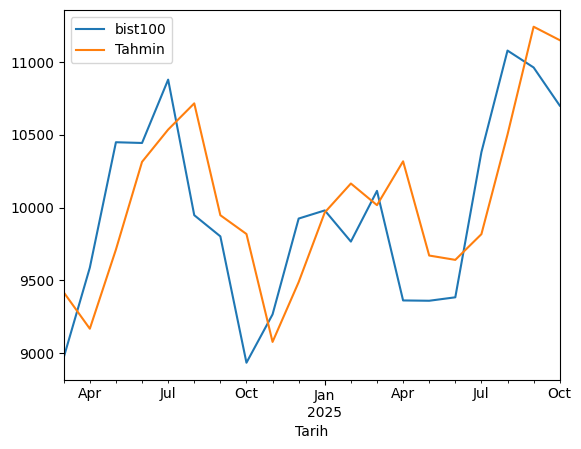

In [89]:
bist.plot()